# Available Classrooms in the Afternoon

In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt

from utils import *

- Select the **date** by specifying the day (*dd*), month (*mm*) and year(*yyyy*).
- Specify a **starting time**. Only the hour is needed (e.g.: if it is set to `12`, it means that the starting time is 12:30)

In [2]:
DAY = "18"
MONTH = "03"
YEAR = "2022"
START_TIME = 12

Select the **classrooms** you want to visualize by writing their name. You can divide them into subgroups: for instance, here they are divided by aisles. You can also specify some **preferred rooms**.

Then, select a **color** for each subgroup.

In [3]:
B_LEFT = ["B01", "B02"]
B_TOP = ["B05", "B06", "B07", "B08", "B09", "B011", "B013"]
B_RIGHT = ["B020", "B021", "B022", "B024"]
B_BOT = ["B029", "B030", "B031", "B032", "B033", "B034"]
OTHER = []

PREFERRED_ROOMS = ["B05"]

SELECTED_ROOMS = B_LEFT + B_TOP + B_RIGHT + B_BOT + OTHER
colors = []
for i in SELECTED_ROOMS:
    if i in PREFERRED_ROOMS:      # preferred rooms:
        colors.append("#FFA493")  # red
    elif i in B_LEFT:             # B section, left aisle:
        colors.append("#DAF7A6")  # green
    elif i in B_TOP:              # B section, top aisle:
        colors.append("#AEFAEA")  # teal
    elif i in B_RIGHT:            # B section, right aisle:
        colors.append("#AEEFFA")  # light blue
    elif i in B_BOT:              # B section, bottom aisle:
        colors.append("#AED2FA")  # blue violet
    else:                         # other rooms:
        colors.append("#C1C1C1")  # grey

Check if the date is valid. If an error occurs, correct the date and restart the kernel.

In [4]:
is_valid_date = True
try:
    datetime.datetime(int(YEAR), int(MONTH), int(DAY))
except ValueError:
    is_valid_date = False

if not is_valid_date:
    print("ERROR: insert a correct date\nKilling the kernel...")
    quit()
else:
    pass

Download the planner and check if there are classes on the specified date. If an error occurs, correct the date and restart the kernel.

In [5]:
planner_url = "https://planner.uniud.it/EasyRoom//index.php?page=4&content=view_prenotazioni&vista=day&area=13&_lang=it&day=" + \
    DAY + "&month=" + MONTH + "&year=" + YEAR
    
Utils.fetch_timetable(planner_url)

df = pd.read_csv("rizzi.csv")

if df.iloc[:, 1:][df.iloc[:, 1:].isnull().all(axis=1)].shape[0] == 55: #if all rows are all NaN 
    print("ERROR: no classes on this day. Change the date.\nKilling the kernel...")
    quit()

Fetching timetable....
Done.


In [6]:
hours = [i for i in range(START_TIME,18)]
data = {i: datetime.datetime(2022, 1, 1, hour=18, minute=30).time()
        for i in SELECTED_ROOMS}

In [7]:
prev_rooms = []

for h in hours:
    curr_time = datetime.datetime(2022, 1, 1, hour=h, minute=30).time()
    curr_rooms = Utils.empty_rooms(
        df, curr_time, 7)  # empty classrooms from `h` to end of the day
    curr_rooms = list(set(SELECTED_ROOMS) & set(curr_rooms))
    curr_rooms = [i for i in curr_rooms if i not in prev_rooms]
    for i in curr_rooms:
        data[i] = curr_time
    prev_rooms.extend(curr_rooms)

In [8]:
data_df = pd.DataFrame.from_dict(data, orient="index", columns=[
                                 "start_time"]).reset_index(level=0).rename(columns={"index": "room"})
data_df["end_time"] = [datetime.datetime(2022, 1, 1, hour=18, minute=30).time()] * data_df.shape[0]
# data_df

In [9]:
data_df["start_time"] = data_df["start_time"].apply(
    lambda x: datetime.datetime.combine(datetime.date.today(), x))
data_df["end_time"] = data_df["end_time"].apply(
    lambda x: datetime.datetime.combine(datetime.date.today(), x))
# data_df

In [10]:
# https://towardsdatascience.com/gantt-charts-with-pythons-matplotlib-395b7af72d72
# start time
start = data_df.start_time.min()
# seconds from start to availability start
data_df["start_num"] = (data_df.start_time - start).dt.seconds
# number of seconds from start to end of availability
data_df["end_num"] = (data_df.end_time - start).dt.seconds
# seconds between start and end of each availability
data_df["duration"] = data_df.end_num - data_df.start_num

# data_df

In [11]:
# add a column with the colors specified at the beginning        
data_df["color"] = colors
# data_df

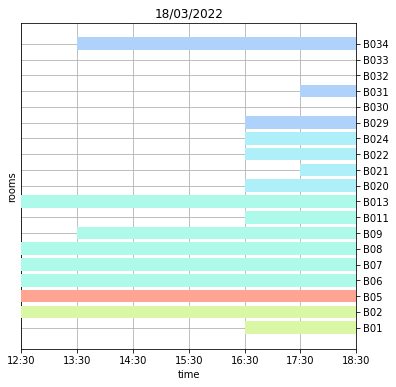

In [12]:
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.grid(zorder=0)
ax.barh(data_df.room, data_df.duration, left=data_df.start_num, color=data_df.color, zorder=3)

ax.set_title(f"{DAY}/{MONTH}/{YEAR}")
ax.set_ylabel("rooms")
ax.set_xlabel("time")

xticks = range(0, data_df.end_num.max()+1, 3600)
xticks_labels = [str(i)[7:-3] for i in list(pd.timedelta_range(start=start.strftime(
    "%H:%M:%S"), end=data_df.end_time.max().strftime("%H:%M:%S"), freq="1H"))]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks_labels)

# ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

plt.show()

Each bar in the graph above is a timeframe in which the corresponding room is available. 

When a room has no bar, it means that there is at least a class that ends at the end time. The room might have some empty time slots after the starting time, but it doesn not have a continuous availability until the end time, thus we don't show it.